In [31]:
### 量化竞争站点变化价格对我方销量的影响
### CompetingStationsPrice_ChangePrice
# 结论1：竞争站点的与我站的柴油价格差，决定了柴油销量
# 结论2：竞争站点的与我站的汽油价格差，无法决定汽油销量。 但我站与我站之前的汽油价格差，会决定汽油销量。
# 结论3：我方站点的价格与竞争对方的价格是强相关的


In [32]:
### STEP1：读取数据 ###
import pandas as pd

COLS_DATE = 'date'
COLS_PRICE = '60000359_price'                   #92号国六B
COLS_PRICE_OTHER = '60000359_price_other'
COLS_ORDER_CNT = '60000359_order_cnt'
COLS_AMOUNT = '60000305_amount'  
# 车流量
COLS_CAR_FLOW_QI = '站前车流量（汽油）'
COLS_CAR_FLOW_CHAI = '站前车流量（柴油）'
COLS_ALL = [COLS_DATE, 
            COLS_PRICE, COLS_PRICE_OTHER, COLS_AMOUNT, COLS_ORDER_CNT,
            COLS_CAR_FLOW_QI, COLS_CAR_FLOW_CHAI
            ]


# 读取excel文件并获取指定列
df = pd.read_csv('../Data/竞争站分析-竞争站-单站-32801817.csv', usecols=COLS_ALL, encoding='GBK')
print(df.head())

       date  站前车流量（汽油）  站前车流量（柴油）  60000359_price 60000359_price_other  \
0  2023/1/1       2430         98            7.20         [5.07, 7.20]   
1  2023/1/2       2376        139            7.20         [5.07, 7.20]   
2  2023/1/3       2524        158            7.20         [5.07, 7.20]   
3  2023/1/4       2538        145            7.41   [5.07, 7.21, 7.41]   
4  2023/1/5       2619        183            7.41         [5.07, 7.41]   

   60000359_order_cnt  60000305_order_cnt  
0                  28                 154  
1                  73                 160  
2                  76                 140  
3                  38                 125  
4                  59                 125  


In [33]:
### STEP2：添加特征列
import CompetingStationPrice_Utils as utils

# 新列：竞争站点价格
df[COLS_PRICE_OTHER] = df[COLS_PRICE_OTHER].apply(utils.get_second_lowest_price)

# 新列：当前油品的差价
df['价格差'] = df[COLS_PRICE] - df[COLS_PRICE_OTHER]        # 我们比对方贵为正数， 便宜为负数

# 新列：当前油品的价格变化（相较前一日）
df['价格变化'] = df[COLS_PRICE] - df[COLS_PRICE].shift(1)
df['价格变化'] = df['价格变化'].fillna(0)

# 新列：当前油品的竞争价格变化
df['竞争站价格变化'] = df[COLS_PRICE_OTHER] - df[COLS_PRICE_OTHER].shift(1)
df['竞争站价格变化'] = df['竞争站价格变化'].fillna(0)



# 新列：当前油品的价差变化
df['价格差变化'] = df['价格差'] - df['价格差'].shift(1)
df['价格差变化'] = df['价格差变化'].fillna(0)

# 新列：总车流量
df['站前车流量'] = df[COLS_CAR_FLOW_QI] + df[COLS_CAR_FLOW_CHAI]
print(df)

           date  站前车流量（汽油）  站前车流量（柴油）  60000359_price  60000359_price_other  \
0      2023/1/1       2430         98            7.20                  7.20   
1      2023/1/2       2376        139            7.20                  7.20   
2      2023/1/3       2524        158            7.20                  7.20   
3      2023/1/4       2538        145            7.41                  7.21   
4      2023/1/5       2619        183            7.41                  7.41   
..          ...        ...        ...             ...                   ...   
360  2023/12/27       2733        145            7.16                  7.01   
361  2023/12/28       2918        141            7.16                  7.01   
362  2023/12/29       3542        129            7.16                  7.01   
363  2023/12/30       3258        118            7.16                  7.01   
364  2023/12/31       3408         98            7.16                  7.01   

     60000359_order_cnt  60000305_order_cnt  价格变化  

站前车流量（汽油）与60000305_order_cnt相关系数：
Pearson相关系数: 0.06980765161714053, p值: 0.18328030589926975
Spearman相关系数: 0.00022119376952003996, p值: 0.9966397941401354
Kendall相关系数: -0.0006958675397962989, p值: 0.9842416255111612


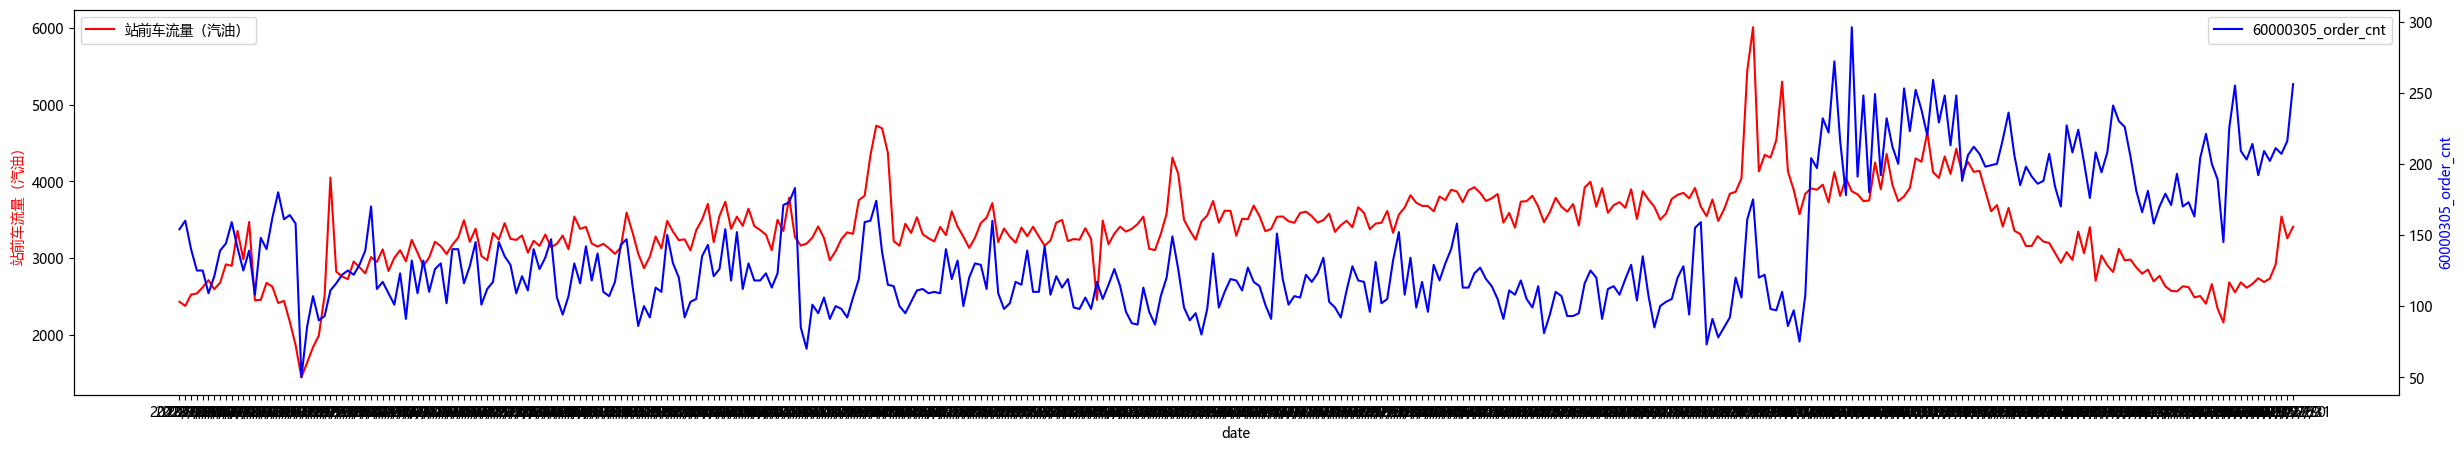

In [34]:
### STEP3：确认相关性

from scipy.stats import pearsonr, spearmanr, kendalltau

# 定义数据列
COLS_X = COLS_DATE
COLS_Y1 = COLS_PRICE  # 检验相关性的两列之一
COLS_Y2 = COLS_CAR_FLOW_QI    # 检验相关性的两列之二

# 确保这两列没有缺失值
df_clean = df[[COLS_Y1, COLS_Y2]].dropna()

# 使用Pearson相关系数计算相关性及p值
pearson_corr, pearson_pvalue = pearsonr(df_clean[COLS_Y1], df_clean[COLS_Y2])
spearman_corr, spearman_pvalue = spearmanr(df_clean[COLS_Y1], df_clean[COLS_Y2])
kendall_corr, kendall_pvalue = kendalltau(df_clean[COLS_Y1], df_clean[COLS_Y2])

# 打印结果
print(F"{COLS_Y1}与{COLS_Y2}相关系数：")
print(f"Pearson相关系数: {pearson_corr}, p值: {pearson_pvalue}")
print(f"Spearman相关系数: {spearman_corr}, p值: {spearman_pvalue}")
print(f"Kendall相关系数: {kendall_corr}, p值: {kendall_pvalue}")

# 打印折线图
import matplotlib.pyplot as plt

# 设置字体，确保能正确显示汉字
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 设置中文字体

# 创建一个图表和轴对象
fig, ax1 = plt.subplots(figsize=(30,5))

# 绘制第一条曲线
ax1.plot(df[COLS_X], df[COLS_Y1], 'r-', label=COLS_Y1)
ax1.set_xlabel(COLS_X)
ax1.set_ylabel(COLS_Y1, color='r')

# 利用twinx()创建第二个Y轴
ax2 = ax1.twinx()

# 绘制第二条曲线
ax2.plot(df[COLS_X], df[COLS_Y2], 'b-', label=COLS_Y2)
ax2.set_ylabel(COLS_Y2, color='b')

# 显示图例
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# 显示图表
plt.show()